In [1]:
!nvidia-smi

Mon Mar 24 09:18:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:31:00.0 Off |                    0 |
| N/A   24C    P8             11W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

# !pip install -q supervision jupyter_bbox_widget

!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

ERROR: Operation cancelled by user
^C
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/football/bin/pip", line 11, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/ubuntu/miniconda3/envs/football/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 80, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/envs/football/lib/python3.11/site-packages/pip/_internal/cli/base_command.py", line 157, in main
    with self.main_context():
  File "/home/ubuntu/miniconda3/envs/football/lib/python3.11/contextlib.py", line 144, in __exit__
    next(self.gen)
  File "/home/ubuntu/miniconda3/envs/football/lib/python3.11/site-packages/pip/_internal/cli/command_context.py", line 19, in main_context
    with self._main_context:
  File "/home/ubuntu/miniconda3/envs/football/lib/python3.11/contextlib.py", line 601, in __exit__
    raise exc_details[1]
  File "/home/ubuntu/miniconda3/envs/football/lib/py

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/ubuntu/projects/sure-football-analysis


In [3]:
from roboflow import Roboflow
# from google.colab import userdata
from IPython.display import Image

In [4]:
from dotenv import load_dotenv

env_path = f"{HOME}/.env"
load_dotenv(dotenv_path=env_path)
ROBOFLOW_API_KEY = os.environ.get("ROBOFLOW_API_KEY")


In [5]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("yolov11")

loading Roboflow workspace...


loading Roboflow project...


In [6]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [7]:
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    # Set default CUDA device
    torch.cuda.set_device(0)
    # Display memory information
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
else:
    print("CUDA is not available. Training will use CPU only.")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA L4
CUDA version: 12.1
Total GPU memory: 23.57 GB
Allocated GPU memory: 0.00 GB
Reserved GPU memory: 0.00 GB


In [9]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-11l-seg.pt", local_dir='.')
# path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-11l-seg-pf.pt", local_dir='.')

In [8]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.train_pe import YOLOETrainer, YOLOEPESegTrainer

In [9]:
%cd {HOME}
# from ultralytics import YOLOE
# from ultralytics.models.yolo.yoloe.train_pe import YOLOEPETrainer, YOLOEPESegTrainer
from ultralytics import YOLO
import os
from ultralytics.nn.tasks import guess_model_scale
from ultralytics.utils import yaml_load, LOGGER
import torch

os.environ["PYTHONHASHSEED"] = "0"  # Disable hash randomization

/home/ubuntu/projects/sure-football-analysis


In [17]:
# model = YOLOE.from_pretrained("jameslahm/yoloe-v8l-seg")

In [17]:
model_path = "yoloe-11l-seg.yaml" 
scale = guess_model_scale(model_path)
print(scale)
default_cfg_path = f"default.yaml"
extend_cfg_path = f"coco_{scale}_train.yaml"
defaults = yaml_load(default_cfg_path)
extends = yaml_load(extend_cfg_path)
assert(all(k in defaults for k in extends))
LOGGER.info(f"Extends: {extends}")

l
Extends: {'overlap_mask': True, 'scale': 0.9, 'mixup': 0.15, 'copy_paste': 0.3}


In [18]:
# Load the model properly for segmentation training
model = YOLOE("yoloe-11l-seg.pt")
# model.load("yoloe-11l-seg.pt")
model.eval()

YOLOE(
  (model): YOLOESegModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

In [19]:
names = yaml_load(f"{dataset.location}/data.yaml")["names"]
print(names)

['ball', 'goalkeeper', 'player', 'referee']


In [20]:
tpe = model.get_text_pe(names)
pe_path = os.path.join(HOME, "yoloe-football.pt")
torch.save({"names": names, "pe": tpe}, pe_path)


Build text model mobileclip:blt


In [21]:

USE_LINEAR_PROBING = False
project_name = "app/models/yoloe"
lr0 = 1e-3
data = f"{dataset.location}/data.yaml"
if USE_LINEAR_PROBING:
    head_index = len(model.model.model) - 1
    freeze = [str(f) for f in range(0, head_index)]
    for name, child in model.model.model[-1].named_children():
        if 'cv3' not in name:
            freeze.append(f"{head_index}.{name}")

    freeze.extend([f"{head_index}.cv3.0.0", f"{head_index}.cv3.0.1", f"{head_index}.cv3.1.0", f"{head_index}.cv3.1.1", f"{head_index}.cv3.2.0", f"{head_index}.cv3.2.1"])

else:
    freeze = None

In [23]:
results = model.train(data=data, epochs=50, close_mosaic=5, batch=2, imgsz=1400,
                      optimizer='AdamW', lr0=lr0, warmup_bias_lr=0.0, plots=True,
                      weight_decay=0.025, momentum=0.9, val_interval=1,
                      device="0", **extends, project=project_name, name="yoloe_football",
                      trainer=YOLOEPESegTrainer, freeze=freeze, train_pe_path=pe_path,
                      )

New https://pypi.org/project/ultralytics/8.3.95 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22478MiB)
engine/trainer: task=segment, mode=train, model=yoloe-11l-seg.pt, data=/home/ubuntu/projects/sure-football-analysis/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=2, imgsz=1400, save=True, save_period=-1, cache=False, device=0, workers=8, project=app/models/yoloe, name=yoloe_football5, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnos

 13                  -1  2   2496512  ultralytics.nn.modules.block.C3k2            [1024, 512, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  2    756736  ultralytics.nn.modules.block.C3k2            [1024, 256, 2, True]          
 17                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  2   2365440  ultralytics.nn.modules.block.C3k2            [768, 512, 2, True]           
 20                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /home/ubuntu/projects/sure-football-analysis/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]
val: Scanning /home/ubuntu/projects/sure-football-analysis/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to app/models/yoloe/yoloe_football5/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.025), 186 bias(decay=0.0)
Image sizes 1408 train, 1408 val
Using 4 dataloader workers
Logging results to app/models/yoloe/yoloe_football5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/149 [00:00<?, ?it/s]


TypeError: ERROR ❌ segment dataset incorrectly formatted or not a segment dataset.
This error can occur when incorrectly training a 'segment' model on a 'detect' dataset, i.e. 'yolo train model=yolov8n-seg.pt data=coco8.yaml'.
Verify your dataset is a correctly formatted 'segment' dataset using 'data=coco8-seg.yaml' as an example.
See https://docs.ultralytics.com/datasets/segment/ for help.

In [ ]:
# Load pre-trained YOLOE model and train on custom data
model = YOLO("yoloe-11l-seg.pt")
# model = YOLOE("yoloe-s.pt")
model.train(data=f"{dataset.location}/data.yaml",
            epochs=50, imgsz=1400, batch=16,
            device=0, project="app/models/yoloe",
            name="yoloe_football", plots=True, lr0=lr0,
            )

FileNotFoundError: [Errno 2] No such file or directory: 'yoloe-s.pt'

Build text model mobileclip:blt


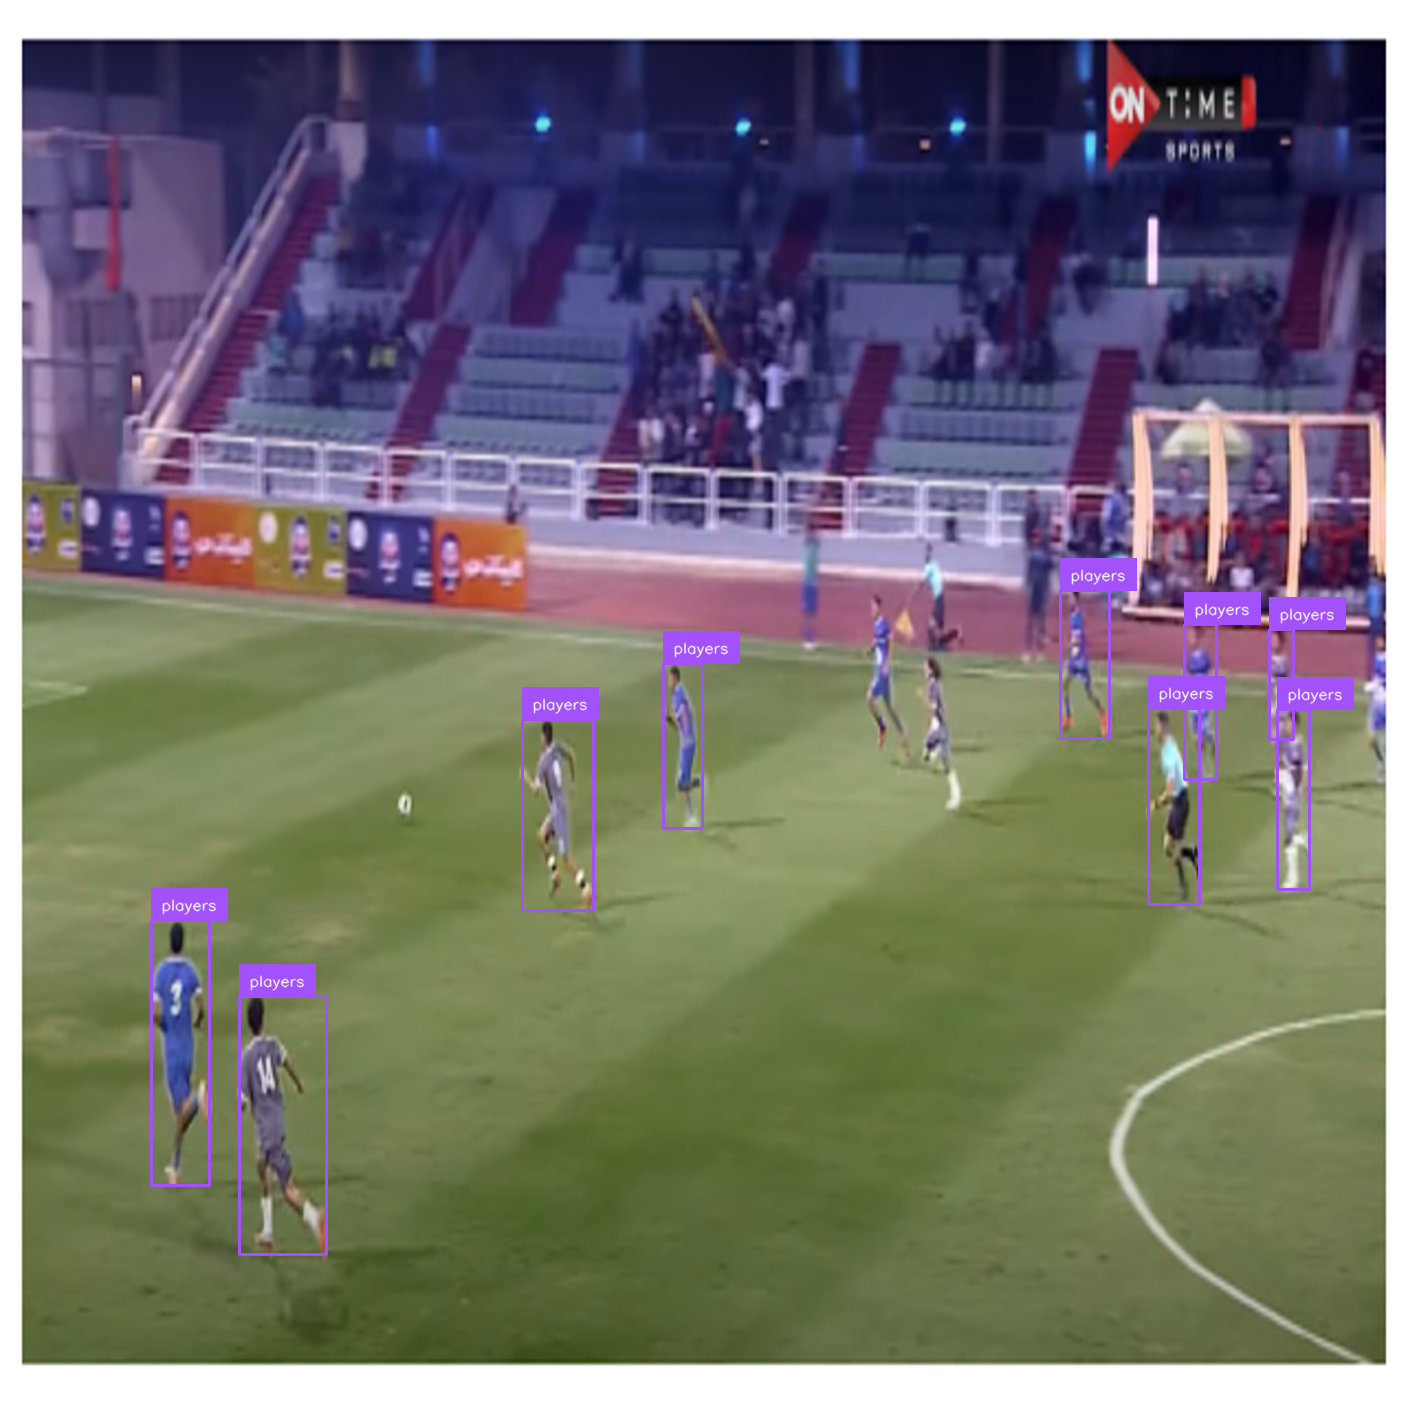

In [28]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

IMAGE_PATH = "app/test_data/raw/capitano_masr1_resized.png"
NAMES = ["players", "ball", "goalkeeper", "referee"]

model = YOLOE("yoloe-11l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

image = Image.open(IMAGE_PATH)
results = model.predict(image, conf=0.1, verbose=False)

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image